In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import cv2
import pathlib
import os
import random
from skimage.io import imread
import horovod.tensorflow as hvd
hvd.init()
from tf_slim.layers import layers as _layers

In [2]:
class DeepCNNModel(object):
    
    def __init__(self):
        self.conv1_1_filter = tf.Variable(tf.random.normal(shape=[3, 3, 3, 64], mean=0, stddev=10e-2)) # third param is RGB, so 3
        self.conv1_2_filter = tf.Variable(tf.random.normal(shape=[3, 3, 64, 64], mean=0, stddev=10e-2)) 
        self.conv2_1_filter = tf.Variable(tf.random.normal(shape=[3, 3, 64, 128], mean=0, stddev=10e-2))
        self.conv2_2_filter = tf.Variable(tf.random.normal(shape=[3, 3, 128, 128], mean=0, stddev=10e-2))
        self.conv3_1_filter = tf.Variable(tf.random.normal(shape=[3, 3, 128, 256], mean=0, stddev=10e-2))
        self.conv3_2_filter = tf.Variable(tf.random.normal(shape=[3, 3, 256, 256], mean=0, stddev=10e-2))
        self.conv3_3_filter = tf.Variable(tf.random.normal(shape=[3, 3, 256, 256], mean=0, stddev=10e-2))
        self.conv4_1_filter = tf.Variable(tf.random.normal(shape=[3, 3, 256, 512], mean=0, stddev=10e-2))    
        self.conv4_2_filter = tf.Variable(tf.random.normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
        self.conv4_3_filter = tf.Variable(tf.random.normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
        self.conv5_1_filter = tf.Variable(tf.random.normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))    
        self.conv5_2_filter = tf.Variable(tf.random.normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
        self.conv5_3_filter = tf.Variable(tf.random.normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
        
        
    def __call__(self, x, rate=0.0):
        conv1_1 = tf.nn.conv2d(x, self.conv1_1_filter, strides=[1,1,1,1], padding='SAME')
        conv1_1 = tf.nn.relu(conv1_1)
        conv1_2 = tf.nn.conv2d(conv1_1, self.conv1_2_filter, strides=[1,1,1,1], padding='SAME')
        conv1_2 = tf.nn.relu(conv1_2)
        conv1_pool = tf.nn.max_pool(conv1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        conv1_bn = tf.keras.layers.BatchNormalization()(conv1_pool)

        conv2_1 = tf.nn.conv2d(conv1_bn, self.conv2_1_filter, strides=[1,1,1,1], padding='SAME')
        conv2_1 = tf.nn.relu(conv2_1)
        conv2_2 = tf.nn.conv2d(conv2_1, self.conv2_2_filter, strides=[1,1,1,1], padding='SAME')
        conv2_2 = tf.nn.relu(conv2_2)
        conv2_pool = tf.nn.max_pool(conv2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
        conv2_bn = tf.keras.layers.BatchNormalization()(conv2_pool)

        conv3_1 = tf.nn.conv2d(conv2_pool, self.conv3_1_filter, strides=[1,1,1,1], padding='SAME')
        conv3_1 = tf.nn.relu(conv3_1)
        conv3_2 = tf.nn.conv2d(conv3_1, self.conv3_2_filter, strides=[1,1,1,1], padding='SAME')
        conv3_2 = tf.nn.relu(conv3_2)
        conv3_3 = tf.nn.conv2d(conv3_2, self.conv3_3_filter, strides=[1,1,1,1], padding='SAME')
        conv3_3 = tf.nn.relu(conv3_3)
        conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
        conv3_bn = tf.keras.layers.BatchNormalization()(conv3_pool)

        conv4_1 = tf.nn.conv2d(conv3_bn, self.conv4_1_filter, strides=[1,1,1,1], padding='SAME')
        conv4_1 = tf.nn.relu(conv4_1)
        conv4_2 = tf.nn.conv2d(conv4_1, self.conv4_2_filter, strides=[1,1,1,1], padding='SAME')
        conv4_2 = tf.nn.relu(conv4_2)
        conv4_3 = tf.nn.conv2d(conv4_2, self.conv4_3_filter, strides=[1,1,1,1], padding='SAME')
        conv4_3 = tf.nn.relu(conv4_3)
        conv4_pool = tf.nn.max_pool(conv4_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
        conv4_bn = tf.keras.layers.BatchNormalization()(conv4_pool)

        conv5_1 = tf.nn.conv2d(conv4_bn, self.conv5_1_filter, strides=[1,1,1,1], padding='SAME')
        conv5_1 = tf.nn.relu(conv5_1)
        conv5_2 = tf.nn.conv2d(conv5_1, self.conv5_2_filter, strides=[1,1,1,1], padding='SAME')
        conv5_2 = tf.nn.relu(conv5_2)
        conv5_3 = tf.nn.conv2d(conv5_2, self.conv5_3_filter, strides=[1,1,1,1], padding='SAME')
        conv5_3 = tf.nn.relu(conv5_3)
        conv5_pool = tf.nn.max_pool(conv5_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
        conv5_bn = tf.keras.layers.BatchNormalization()(conv5_pool)

        flat = _layers.flatten(conv5_bn)  

        full1 = _layers.fully_connected(inputs=flat, num_outputs=4096, activation_fn=tf.nn.relu) #fc6
        full1 = tf.nn.dropout(full1, rate=rate)
        full1 = tf.keras.layers.BatchNormalization()(full1)

        out = _layers.fully_connected(inputs=full1, num_outputs=len(label_names), activation_fn=None) #fc8

        logits = tf.identity(out, name='logits')
        return logits
        

In [3]:
def model_fn(features, labels, mode, params):
    model = DeepCNNModel()
    model_x = model(features["input_img"])
    _,top_5 =  tf.nn.top_k(model_x,k=5)
    predictions = {
        'top_1': tf.argmax(model_x, -1),
        'top_5': top_5,
        'probabilities': tf.nn.softmax(model_x),
        'logits': model_x,
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    

In [4]:
def predict(img_data):
    class_num, class_name, confidence = None, None, 0.
    image = img_data
    im_data = tf.reshape(image, [1, IMAGE_SIZE, IMAGE_SIZE, 3])
    im_data = tf.cast(im_data, tf.float32)
    im_data = im_data.numpy()
    

    
    checkpoint_dir = '../../data/vgg-models/checkpoints-1e3x4-2e4-09202019'            
    latest = tf.train.latest_checkpoint(checkpoint_dir)        
    checkpoint = tf.train.Checkpoint()
    status = checkpoint.restore(latest)
    #loader = tf.compat.v1.train.import_meta_graph(latest+'.meta')

    my_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
        x={"input_img": im_data},
        shuffle=False,
        batch_size=1)

    predictor = tf.estimator.Estimator(model_fn=model_fn, model_dir=checkpoint_dir)
    predictions = predictor.predict(input_fn=my_input_fn)

    final_result = None
    print(predictions)
    for result in predictions:
        final_result = result

    print(final_result["top_5"])
    logits_out = final_result["logits"]
    print(logits_out)

    class_num = np.argmax(logits_out, axis=0)
    class_name = label_names[class_num]
    confidence = logits_out[class_num]
    all_preds = logits_out
            
            
    return (class_num, class_name, confidence, all_preds)

In [5]:
def get_celeb_box(df, name, img_num):
    the_box_row = df.loc[df['CELEB']==name]
    the_box_row = the_box_row.iloc[img_num]
    return the_box_row[['LEFT', 'TOP', 'RIGHT', 'BOTTOM']].values

In [6]:
def get_celeb_url(df, name, img_num):
    the_url_row = df.loc[df['CELEB']==name].iloc[img_num]['URL']
    return the_url_row

In [7]:
def bbox_on_img(url, bbox):
    image = imread(url)
    plt.figure()
    plt.imshow(image)
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    
    w=x2-x1
    h=y2-y1
    rect = Rectangle((x1, y1), w, h, fill=False, color='r')
    plt.axes().add_patch(rect)
    plt.show()   

In [8]:
def get_clip_image(url, bbox):
    image = imread(url)
    
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    
    w=x2-x1
    h=y2-y1
    
    crop_img = image[y1:y1+h, x1:x1+w]
    new_size = IMAGE_SIZE, IMAGE_SIZE
    crop_img = cv2.resize(crop_img, new_size, interpolation=cv2.INTER_CUBIC)
    #crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
    return crop_img

In [9]:
IMAGE_SIZE=64

In [10]:
data_root_orig = '../../data/vgg_face'
data_root = pathlib.Path(data_root_orig)

In [11]:
celeb_root = pathlib.Path('../../data/vgg_face_dataset/files/')
celebs_to_test = list(celeb_root.glob('*.txt'))
#print(celebs_to_test)
celebs_to_test = [str(c).split('.')[4].split('/')[4] for c in celebs_to_test]
#print(celebs_to_test)
print(len(celebs_to_test))

all_image_paths = []
for c in celebs_to_test:
    all_image_paths += list(data_root.glob(c+'/*')) 

all_image_paths_c = []
for p in all_image_paths:
    path_str = os.path.basename(str(p))
    if path_str.startswith('._'):
        print('Rejecting '+str(p))
    else:
        all_image_paths_c.append(p)

all_image_paths = all_image_paths_c
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

2622


1903

In [12]:
label_names = sorted(celebs_to_test)
label_names

['A',
 'A',
 'A_P_J_Abdul_Kalam',
 'Aamir_Khan',
 'Aaron_Staton',
 'Aaron_Tveit',
 'Aaron_Yoo',
 'Abbie_Cornish',
 'Abel_Ferrara',
 'Abigail_Breslin',
 'Abigail_Klein',
 'Abigail_Spencer',
 'Abraham_Benrubi',
 'Adam_Baldwin',
 'Adam_Beach',
 'Adam_Brody',
 'Adam_Buxton',
 'Adam_Copeland',
 'Adam_Driver',
 'Adam_G',
 'Adam_Garcia',
 'Adam_Godley',
 'Adam_Goldberg',
 'Adam_Gregory',
 'Adam_Hicks',
 'Adam_Lambert',
 'Adam_Levine',
 'Adam_Rodriguez',
 'Adelaide_Clemens',
 'Adelaide_Kane',
 'Adina_Porter',
 'Aditya_Roy_Kapoor',
 'Adrian_Grenier',
 'Adrian_Paul',
 'Adriana_Barraza',
 'Adrianne_Curry',
 'Adrianne_Palicki',
 'Adrienne_Barbeau',
 'Agyness_Deyn',
 'Aida_Turturro',
 'Aidan_Gillen',
 'Aidan_Turner',
 'Ajay_Devgn',
 'Akshay_Kumar',
 'Alain_Delon',
 'Alan_Alda',
 'Alan_Cumming',
 'Alan_Dale',
 'Alan_Ladd',
 'Alan_Rickman',
 'Alan_Tudyk',
 'Alba_Rohrwacher',
 'Aldis_Hodge',
 'Alessandra_Torresani',
 'Alex_Borstein',
 'Alex_Kingston',
 'Alex_Newell',
 'Alex_Pettyfer',
 'Alex_Trebek',


In [13]:
valid_face_urls_path = '../../data/vgg_face_full_urls.csv'
face_urls_path = '../data/../vgg_face_full.csv'

if not os.path.exists(valid_face_urls_path):  
    path = '../../data/vgg_face_dataset/files'
    for (dirpath, dirnames, filenames) in os.walk(path):
        df = None
        for filename in tqdm(filenames):
            if filename.endswith('.txt'): 
                celeb_name = os.path.splitext(filename)[0]
                full_path = os.sep.join([dirpath, filename])
                #print("Processing: ["+celeb_name+"]: full path: ["+full_path+"]")
                if df is not None:
                    df = df.append(process_celeb(celeb_name,  full_path))
                else:
                    df = process_celeb(celeb_name, full_path)
    
    df.to_csv(face_urls_path)
    print('Num Celeb Images', str(len(df)))
else:
    # run the script vgg_valid_url.py and change n_cores to how many parallel proc you want validating the URLs
    # running this script will yield a new dataframe saved in the file that you are opening below with a new 
    # column, VALID_URL set to True if the result of requests.head(url, timeout=0.0001) is 200, else False
    df = pd.read_csv(valid_face_urls_path)   

Celeb Name Aamir_Khan
Pic Num 78
[74.62 93.19 241.43 260.0]
http://4.bp.blogspot.com/-lyZ9vVVSy04/UIGUU6kUb2I/AAAAAAAAALU/xbXxYAnSdII/s320/Amir-Khan.jpg


<ipython-input-7-7fa74e61d762>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().add_patch(rect)


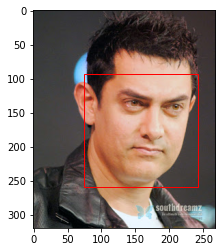

In [27]:
celeb_name = label_names[random.randint(0,3)]
c_num = random.randint(0,300)
print('Celeb Name', celeb_name)
print('Pic Num', c_num)
c_box =  get_celeb_box(df, celeb_name, c_num)
print(c_box)
c_url= get_celeb_url(df, celeb_name, c_num)
print(c_url)
bbox_on_img(c_url, c_box)

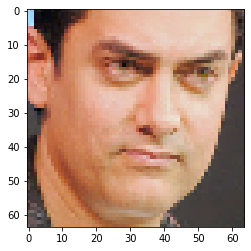

In [28]:
p_img = get_clip_image(c_url, c_box)
plt.figure()
plt.imshow(p_img)

In [29]:
tf.train.list_variables('../../data/vgg-models/checkpoints-1e3x4-2e4-09202019')

[('Variable', [3, 3, 3, 64]),
 ('Variable/Adam', [3, 3, 3, 64]),
 ('Variable/Adam_1', [3, 3, 3, 64]),
 ('Variable_1', [3, 3, 64, 64]),
 ('Variable_1/Adam', [3, 3, 64, 64]),
 ('Variable_1/Adam_1', [3, 3, 64, 64]),
 ('Variable_10', [3, 3, 512, 512]),
 ('Variable_10/Adam', [3, 3, 512, 512]),
 ('Variable_10/Adam_1', [3, 3, 512, 512]),
 ('Variable_11', [3, 3, 512, 512]),
 ('Variable_11/Adam', [3, 3, 512, 512]),
 ('Variable_11/Adam_1', [3, 3, 512, 512]),
 ('Variable_12', [3, 3, 512, 512]),
 ('Variable_12/Adam', [3, 3, 512, 512]),
 ('Variable_12/Adam_1', [3, 3, 512, 512]),
 ('Variable_2', [3, 3, 64, 128]),
 ('Variable_2/Adam', [3, 3, 64, 128]),
 ('Variable_2/Adam_1', [3, 3, 64, 128]),
 ('Variable_3', [3, 3, 128, 128]),
 ('Variable_3/Adam', [3, 3, 128, 128]),
 ('Variable_3/Adam_1', [3, 3, 128, 128]),
 ('Variable_4', [3, 3, 128, 256]),
 ('Variable_4/Adam', [3, 3, 128, 256]),
 ('Variable_4/Adam_1', [3, 3, 128, 256]),
 ('Variable_5', [3, 3, 256, 256]),
 ('Variable_5/Adam', [3, 3, 256, 256]),
 ('V

In [30]:
class_num2, class_name2, confidence2, all_preds2 = predict(p_img)

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../../data/vgg-models/checkpoints-1e3x4-2e4-09202019', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol':

In [31]:
print('Class_Num', class_num2)
print('Class_Name', class_name2)
print('Confidence', str(confidence2))
print(all_preds2)

print(label_names)

Class_Num 3
Class_Name Aamir_Khan
Confidence 502.8813
[ 138.8458    -29.522411  -65.23301  ... -130.23811    -7.52309
  -28.505346]
['A', 'A', 'A_P_J_Abdul_Kalam', 'Aamir_Khan', 'Aaron_Staton', 'Aaron_Tveit', 'Aaron_Yoo', 'Abbie_Cornish', 'Abel_Ferrara', 'Abigail_Breslin', 'Abigail_Klein', 'Abigail_Spencer', 'Abraham_Benrubi', 'Adam_Baldwin', 'Adam_Beach', 'Adam_Brody', 'Adam_Buxton', 'Adam_Copeland', 'Adam_Driver', 'Adam_G', 'Adam_Garcia', 'Adam_Godley', 'Adam_Goldberg', 'Adam_Gregory', 'Adam_Hicks', 'Adam_Lambert', 'Adam_Levine', 'Adam_Rodriguez', 'Adelaide_Clemens', 'Adelaide_Kane', 'Adina_Porter', 'Aditya_Roy_Kapoor', 'Adrian_Grenier', 'Adrian_Paul', 'Adriana_Barraza', 'Adrianne_Curry', 'Adrianne_Palicki', 'Adrienne_Barbeau', 'Agyness_Deyn', 'Aida_Turturro', 'Aidan_Gillen', 'Aidan_Turner', 'Ajay_Devgn', 'Akshay_Kumar', 'Alain_Delon', 'Alan_Alda', 'Alan_Cumming', 'Alan_Dale', 'Alan_Ladd', 'Alan_Rickman', 'Alan_Tudyk', 'Alba_Rohrwacher', 'Aldis_Hodge', 'Alessandra_Torresani', 'Alex_B